In [16]:
from itertools import pairwise, accumulate

import polars as pl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.signal import savgol_filter

In [17]:
r = 6378000

In [18]:
df = pl.read_csv(
    'data/data.csv',
    separator=';'
)

In [19]:
df = df.with_columns(*(i.str.replace(',', '.').cast(pl.Float64) for i in df if i.dtype == pl.Utf8 and i.name != 'Date'))
    

In [20]:
df = df.with_columns(
    (df['Date'] + ' ' + df['Hours'] + ':' + df['Minutes'] + ':' + df['Seconds'])
    .alias('DateTime').str
    .to_datetime('%m/%d/%Y %H:%M:%S%.f')
)
df = df.sort(by='DateTime')

In [21]:
filtering_df = df.describe()
filtering_df = filtering_df.filter(filtering_df['describe'].is_in(('25%', '75%')))
filtering_df = filtering_df.select(*(i for i in filtering_df if i.dtype == pl.Float64))
filtering_df

AccelerationX,AccelerationY,AccelerationZ,GyroscopeX,GyroscopeY,GyroscopeZ,Latitude,Longitude,Velocity,Altitude,Position,Hours,Minutes,Seconds
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-0.08527,-0.04583,0.9947,-0.85337,-0.41535,-1.05459,45.080837,14.120643,12.4084,54.0,67.5,11.0,17.0,14.82
-0.02348,0.04216,1.00988,-0.02646,0.41936,1.07079,45.096867,14.156328,35.0028,259.0,291.6,11.0,48.0,44.992


In [22]:
def valid_range(q1: float, q3: float) -> tuple[float, float]:
    iqr = q3 - q1
    
    return q1 - 1.5 * iqr, q3 + 1.5 * iqr

In [23]:
f_dict = {i.name: valid_range(*i) for i in filtering_df}
f_dict

{'AccelerationX': (-0.17795499999999997, 0.06920499999999999),
 'AccelerationY': (-0.17781500000000003, 0.17414500000000002),
 'AccelerationZ': (0.97193, 1.0326500000000003),
 'GyroscopeX': (-2.0937349999999997, 1.213905),
 'GyroscopeY': (-1.667415, 1.671425),
 'GyroscopeZ': (-4.24266, 4.258859999999999),
 'Latitude': (45.056792, 45.120912000000004),
 'Longitude': (14.067115499999998, 14.209855500000002),
 'Velocity': (-21.483199999999997, 68.89439999999999),
 'Altitude': (-253.5, 566.5),
 'Position': (-268.65000000000003, 627.75),
 'Hours': (11.0, 11.0),
 'Minutes': (-29.5, 94.5),
 'Seconds': (-30.437999999999995, 90.25)}

In [24]:
df = df.filter(
    *(i.is_between(*f_dict[i.name]) for i in df if i.dtype == pl.Float64)
)

In [25]:
df

AccelerationX,AccelerationY,AccelerationZ,GyroscopeX,GyroscopeY,GyroscopeZ,Latitude,Longitude,Velocity,Altitude,Position,Hours,Minutes,Seconds,Date,DateTime
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,str,datetime[ns]
-0.03746,0.00906,1.00531,-0.30144,-0.07819,0.23741,45.085692,14.15682,2.2224,157.7,58.0,10,44,57.688,"""06/01/2021""",2021-06-01 10:44:57.688
-0.03726,0.00946,1.00547,-0.31056,-0.07654,0.25652,45.085692,14.156818,2.2224,157.7,60.6,10,44,57.786,"""06/01/2021""",2021-06-01 10:44:57.786
-0.03717,0.00948,1.00595,-0.31761,-0.08085,0.20801,45.08569,14.156818,2.4076,157.8,61.6,10,44,58.041,"""06/01/2021""",2021-06-01 10:44:58.041
-0.03716,0.00961,1.00563,-0.31059,-0.06915,0.28669,45.08569,14.156818,2.5928,157.8,56.1,10,44,58.297,"""06/01/2021""",2021-06-01 10:44:58.297
-0.03734,0.00946,1.00576,-0.31592,-0.08214,0.16084,45.085692,14.156818,2.5928,157.7,52.0,10,44,58.554,"""06/01/2021""",2021-06-01 10:44:58.554
-0.03693,0.00928,1.00571,-0.32445,-0.0777,0.31299,45.085692,14.156818,2.5928,157.7,54.2,10,44,58.809,"""06/01/2021""",2021-06-01 10:44:58.809
-0.03725,0.00942,1.00595,-0.31789,-0.08837,0.27719,45.085693,14.15682,2.5928,157.6,53.8,10,44,59.065,"""06/01/2021""",2021-06-01 10:44:59.065
-0.03693,0.00875,1.00573,-0.3129,-0.096,0.2537,45.085693,14.156818,2.5928,157.6,48.5,10,44,59.321,"""06/01/2021""",2021-06-01 10:44:59.321
-0.03726,0.00974,1.00616,-0.31325,-0.06636,0.26604,45.085693,14.156818,2.4076,157.7,49.8,10,44,59.577,"""06/01/2021""",2021-06-01 10:44:59.577


In [26]:
df = df.rolling(
    'DateTime',
    period='500ms'
).agg(
    *(pl.mean(i.name) for i in df if i.name not in ('Date', 'Hours', 'Minutes', 'Seconds', 'DateTime'))
)

In [27]:
df = df.with_columns(
    pl.Series(np.sqrt(
        np.power(df['AccelerationX'], 2)
        + np.power(df['AccelerationY'], 2)
        + np.power(df['AccelerationZ'] - 1, 2)
    ) * 9.81).alias('Acceleration'),
    pl.Series(2 * r * np.arcsin(
        np.sqrt(
            np.power(np.sin(np.deg2rad(df['Longitude']) / 2), 2)
            + np.cos(0) * np.power(np.sin(np.deg2rad(0) / 2), 2)
        )
    )).alias('Y'),
    pl.Series(2 * r * np.arcsin(
        np.sqrt(
            np.power(np.sin(np.deg2rad(0) / 2), 2)
            + np.cos(0) * np.power(np.sin(np.deg2rad(df['Latitude']) / 2), 2)
        )
    )).alias('X'),
    df['Velocity'] / 3.6
)

In [28]:
df

DateTime,AccelerationX,AccelerationY,AccelerationZ,GyroscopeX,GyroscopeY,GyroscopeZ,Latitude,Longitude,Velocity,Altitude,Position,Acceleration,Y,X
datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2021-06-01 10:44:57.688,-0.03746,0.00906,1.00531,-0.30144,-0.07819,0.23741,45.085692,14.15682,0.617333,157.7,58.0,0.38165,1.5759e6,5.0188e6
2021-06-01 10:44:57.786,-0.03736,0.00926,1.00539,-0.306,-0.077365,0.246965,45.085692,14.156819,0.617333,157.7,59.3,0.381276,1.5759e6,5.0188e6
2021-06-01 10:44:58.041,-0.037297,0.009333,1.005577,-0.30987,-0.078527,0.23398,45.085691,14.156819,0.634481,157.733333,60.066667,0.38111,1.5759e6,5.0188e6
2021-06-01 10:44:58.297,-0.037165,0.009545,1.00579,-0.3141,-0.075,0.24735,45.08569,14.156818,0.6945,157.8,58.85,0.380682,1.5759e6,5.0188e6
2021-06-01 10:44:58.554,-0.03725,0.009535,1.005695,-0.313255,-0.075645,0.223765,45.085691,14.156818,0.720222,157.75,54.05,0.381319,1.5759e6,5.0188e6
2021-06-01 10:44:58.809,-0.037135,0.00937,1.005735,-0.320185,-0.07992,0.236915,45.085692,14.156818,0.720222,157.7,53.1,0.379901,1.5759e6,5.0188e6
2021-06-01 10:44:59.065,-0.03709,0.00935,1.00583,-0.32117,-0.083035,0.29509,45.085692,14.156819,0.720222,157.65,54.0,0.37957,1.5759e6,5.0188e6
2021-06-01 10:44:59.321,-0.03709,0.009085,1.00584,-0.315395,-0.092185,0.265445,45.085693,14.156819,0.720222,157.6,51.15,0.378965,1.5759e6,5.0188e6
2021-06-01 10:44:59.577,-0.037095,0.009245,1.005945,-0.313075,-0.08118,0.25987,45.085693,14.156818,0.6945,157.65,49.15,0.379541,1.5759e6,5.0188e6


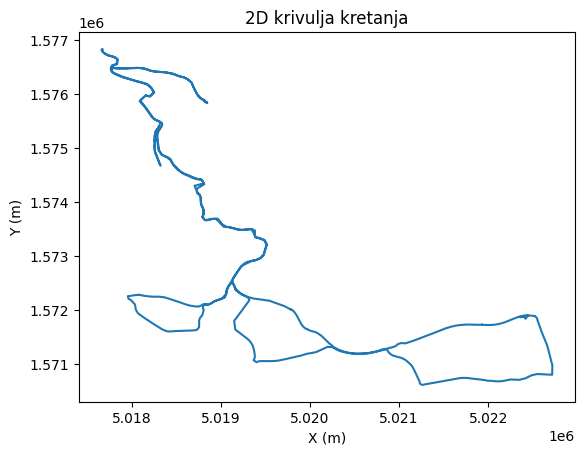

In [29]:
plt.plot(
    df['X'],
    df['Y']
)
plt.title('2D krivulja kretanja')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.show()

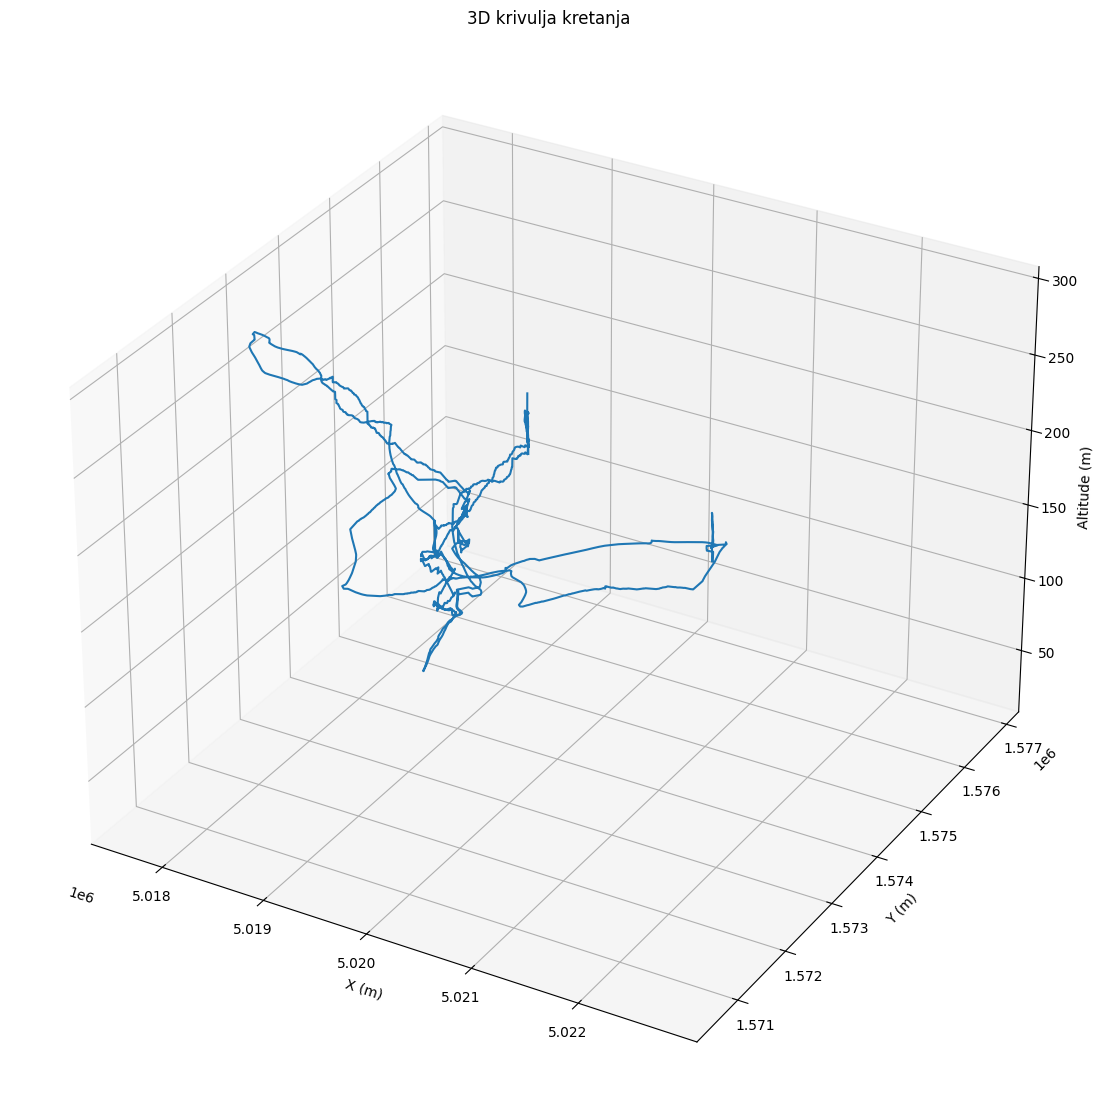

In [30]:
fig = plt.figure(figsize=(16, 14))
ax = fig.add_subplot(111, projection='3d')
ax.plot(
    df['X'], 
    df['Y'], 
    savgol_filter(df['Altitude'], 1000, 5)
)
ax.set_title('3D krivulja kretanja')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Altitude (m)')

plt.show()